In [5]:
import pandas as pd
data=pd.read_csv("./datasets/english.csv")
txt=" ".join(data["sentence"])
txt.replace("-"," ")
mots=txt.split(" ")
vocab=list(set(mots))
id2word={i:v for i,v in enumerate(vocab) if v!=''}
word2id={v:i for i,v in enumerate(vocab) if v!=''}
def tokenize(vocabulary, target):
    tokenization = []
    for char in target:
        tokenization.append(vocabulary[char])
    return tokenization

def tokenize_dataset(exemples):
    tokenized_exemples=[tokenize(word2id,e.split(" ")) for e in exemples]
    return tokenized_exemples
def get_xy(seq):
    x = seq[:-1]
    y = seq[1:]
    return x, y
tokenized_dataset=tokenize_dataset(data["sentence"])
def aplypadding(objectif,liste):
    if len(liste)<objectif:
        differnce=objectif-len(liste)
        liste_dif=[0 for _ in range(differnce)]
        liste.extend(liste_dif)
    if len(liste)>objectif:
        liste=liste[:objectif]

    return liste
def pad_dataset(exemples):
    tokenized_exemples=[aplypadding(70,e) for e in exemples]
    return tokenized_exemples
import torch
padded_data=pad_dataset(tokenized_dataset)
tokens=torch.tensor(padded_data)
tokens=torch.tensor(padded_data)
data = tokens[:, :-1]   # tout sauf le dernier
labels = tokens[:, 1:]    # tout sauf le premier
tokens=torch.tensor(padded_data)
data = tokens[:, :-1]   # tout sauf le dernier
labels = tokens[:, 1:]    
def split_data(x,y,test_size):
        indices = torch.randperm(len(x))
        size = int(len(x) *test_size)
        x = x[indices]
        y = y[indices]
        return x[:size], y[:size], x[size:], y[size:]


x_train,y_train,x_test,y_test=split_data(data,labels,0.25)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# =========================
# 1. Définition du modèle
# =========================
class Rnn_model(nn.Module):
    def __init__(self, vocab_size, d_model=256, hidden_size=128, output_size=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model,padding_idx=0)
        self.lstm = nn.LSTM(d_model, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size if output_size else vocab_size)
    
    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.embedding(x)                         # (batch, seq_len, d_model)
        out, _ = self.lstm(emb)                         # (batch, seq_len, hidden)
        logits = self.fc(out)                           # (batch, seq_len, vocab_size)
        return logits

# =========================
# 2. Accuracy function
# =========================
def accuracy_fn(y_true, y_pred):
    """
    y_true: (batch, seq_len) entiers
    y_pred: (batch, seq_len, vocab_size) logits
    """
    preds = y_pred.argmax(dim=-1)                      # (batch, seq_len)
    correct = (preds == y_true).float().sum()
    total = torch.numel(y_true)
    return (correct / total * 100).item()

# =========================
# 3. Boucle d'entraînement
# =========================
def train_rnn(model, train_data, val_data, epochs=10, lr=1e-3, batch_size=32, device="cpu"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = train_data
    X_val, y_val = val_data

    num_batches = len(X_train) // batch_size
    num_val_batches = len(X_val) // batch_size

    # Listes pour stocker les métriques de chaque epoch
    all_train_losses = []
    all_train_accs = []
    all_val_losses = []
    all_val_accs = []

    for epoch in range(epochs):
        model.train()
        train_losses, train_accs = [], []
        
        for i in range(num_batches):
            start, end = i * batch_size, (i + 1) * batch_size
            xb, yb = X_train[start:end].to(device), y_train[start:end].to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accs.append(accuracy_fn(yb, logits))

        # ================= Validation =================
        model.eval()
        val_losses, val_accs = [], []
        with torch.no_grad():
            for i in range(num_val_batches):
                start, end = i * batch_size, (i + 1) * batch_size
                xb, yb = X_val[start:end].to(device), y_val[start:end].to(device)

                logits = model(xb)
                loss = criterion(logits.view(-1, logits.size(-1)), yb.view(-1))

                val_losses.append(loss.item())
                val_accs.append(accuracy_fn(yb, logits))

        # Calculer les moyennes de l'epoch
        epoch_train_loss = sum(train_losses) / len(train_losses)
        epoch_train_acc = sum(train_accs) / len(train_accs)
        epoch_val_loss = sum(val_losses) / len(val_losses)
        epoch_val_acc = sum(val_accs) / len(val_accs)

        # Ajouter aux listes globales
        all_train_losses.append(epoch_train_loss)
        all_train_accs.append(epoch_train_acc)
        all_val_losses.append(epoch_val_loss)
        all_val_accs.append(epoch_val_acc)

        # ================= Résultats =================
        print(f"Epoch {epoch+1} | "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val Acc: {epoch_val_acc:.2f}%")

    return all_train_losses, all_train_accs, all_val_losses, all_val_accs

tokens = torch.tensor(padded_data)

# Décalage pour language modeling
data = tokens[:, :-1]    # input
labels = tokens[:, 1:]   # target

def split_data(x, y, test_size=0.25):
    indices = torch.randperm(len(x))
    size = int(len(x) * test_size)
    x = x[indices]
    y = y[indices]
    return x[size:], y[size:], x[:size], y[:size]  # (train, test)

x_train, y_train, x_test, y_test = split_data(data, labels, 0.25)

print("x_train:", x_train.shape)   # (nb_sequences, seq_len-1)
print("y_train:", y_train.shape)   # (nb_sequences, seq_len-1)
vocab_size = len(vocab) + 1
print(vocab_size)
model = Rnn_model(vocab_size=vocab_size, d_model=256, hidden_size=128)

train_losses, train_accs, val_losses, val_accs = train_rnn(
    model, (x_train, y_train), (x_test, y_test), 
    epochs=10, lr=1e-3, batch_size=32, device="cpu"
)


x_train: torch.Size([673, 69])
y_train: torch.Size([673, 69])
2883
Epoch 1 | Train Loss: 6.9518 | Train Acc: 57.72% | Val Loss: 3.6070 | Val Acc: 87.89%
Epoch 2 | Train Loss: 1.6993 | Train Acc: 87.41% | Val Loss: 1.1046 | Val Acc: 87.93%
Epoch 3 | Train Loss: 1.1028 | Train Acc: 87.41% | Val Loss: 1.0584 | Val Acc: 87.97%
Epoch 4 | Train Loss: 1.0204 | Train Acc: 87.47% | Val Loss: 1.0001 | Val Acc: 88.00%
Epoch 5 | Train Loss: 0.9536 | Train Acc: 87.55% | Val Loss: 0.9636 | Val Acc: 88.02%
Epoch 6 | Train Loss: 0.9092 | Train Acc: 87.58% | Val Loss: 0.9416 | Val Acc: 88.04%
Epoch 7 | Train Loss: 0.8771 | Train Acc: 87.66% | Val Loss: 0.9298 | Val Acc: 88.09%
Epoch 8 | Train Loss: 0.8522 | Train Acc: 87.72% | Val Loss: 0.9233 | Val Acc: 88.15%
Epoch 9 | Train Loss: 0.8311 | Train Acc: 87.81% | Val Loss: 0.9191 | Val Acc: 88.21%
Epoch 10 | Train Loss: 0.8117 | Train Acc: 87.92% | Val Loss: 0.9155 | Val Acc: 88.26%


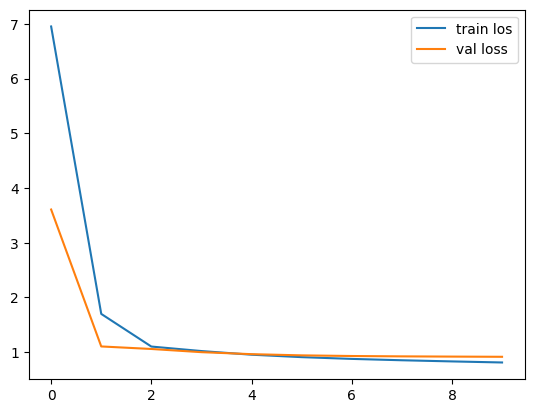

In [9]:
import matplotlib.pyplot as plt
plt.plot(range(10),train_losses,label="train los")
plt.plot(range(10),val_losses,label="val loss")
plt.legend()

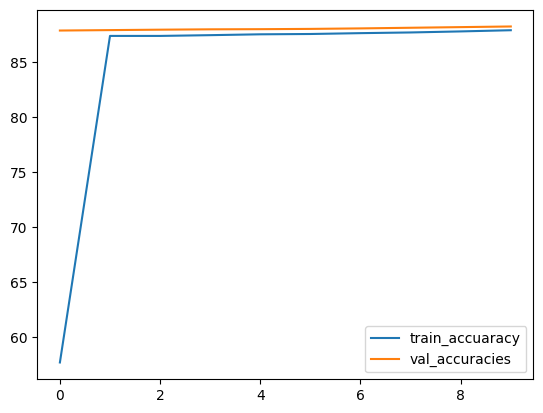

In [10]:
plt.plot(range(10),train_accs,label="train_accuaracy")
plt.plot(range(10),val_accs,label="val_accuracies")
plt.legend()